## Integral by Interpolation ##

We want to use a NN to calculate the integral $I$ of a polynomial function in the form of: 

$$I = \int_{0}^{B} (αx^2 + βx + γ)\, dx \, \Longrightarrow$$ 
$$ = \frac{α}{3}B^3 + \frac{β}{2}B^2 + γB $$ 

In [430]:
# Command
%load_ext autoreload
%autoreload 2

# Modules 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import generate_poly_dataset as gen_poly
import generic as gc
import split_dataset as data_split


# Paths
cur_path = os.getcwd()
path_to_data = os.path.join(cur_path, 'data')
path_to_models = os.path.join(cur_path, 'models')
data = os.path.join(path_to_data, 'poly_data.npy')

# Parameters
torch.set_default_dtype(torch.float32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get dataset

In [431]:
poly_data = np.load(data) # Load polynomials numpy array
poly_data = poly_data[:10000]
poly_data = poly_data[:, :-1], poly_data[:, -1]
transformed_dataset = gen_poly.PolyDataset(poly_data, transform=gen_poly.ToTensor())
X, y = transformed_dataset.data
print(X.shape, y.shape)

(10000, 4) (10000,)


Split dataset

In [432]:
training_data, test_data = data_split.split_dataset(transformed_dataset, seed=42)

In [433]:
batch_size = 64

# Create data loaders.

train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size,
                             shuffle=True)

for X, y in test_dataloader:
    print(f'Shape of X [α, β, γ, B]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [α, β, γ, B]: torch.Size([64, 4])
Shape of y: torch.Size([64]) torch.float32


Define NN architecture

In [434]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() 
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 1),
        ) 
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
nodes_update = [64, 32, 16, 8]
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [435]:
# Count model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

3073


Defining model

In [436]:
# Loss function and optimizer

lr = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Train the model

In [437]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate((dataloader)):
        X, y  = X.to(device), y.to(device)
        # Compute prediction error
        y_pred = model(X)
        y_pred = np.squeeze(y_pred)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f} [{current:>5d}]/{size:>5d}]")
        return loss

Test model

In [438]:
def test(dataloader, model, loss_fn):
    ref_pct = 0.01
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred = np.squeeze(y_pred)
            test_loss += loss_fn(y_pred, y).item()
            correct += (torch.abs(y_pred - y) < torch.abs(ref_pct*y)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test error: \n Accuracy {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct*100

  0%|          | 0/200 [00:00<?, ?it/s]

Test error: 
 Accuracy 0.0%, Avg loss: 0.972423 

Test error: 
 Accuracy 0.0%, Avg loss: 0.890875 

Test error: 
 Accuracy 0.0%, Avg loss: 0.794927 

Test error: 
 Accuracy 0.0%, Avg loss: 0.669464 

Test error: 
 Accuracy 0.1%, Avg loss: 0.516560 

Test error: 
 Accuracy 0.4%, Avg loss: 0.345646 

Test error: 
 Accuracy 1.0%, Avg loss: 0.182082 

Test error: 
 Accuracy 2.0%, Avg loss: 0.082542 

Test error: 
 Accuracy 3.1%, Avg loss: 0.130902 

Test error: 
 Accuracy 1.4%, Avg loss: 0.247346 

Test error: 
 Accuracy 1.4%, Avg loss: 0.242017 

Test error: 
 Accuracy 2.4%, Avg loss: 0.170476 

Test error: 
 Accuracy 2.9%, Avg loss: 0.101853 

Test error: 
 Accuracy 2.4%, Avg loss: 0.071587 

Test error: 
 Accuracy 2.1%, Avg loss: 0.074835 

Test error: 
 Accuracy 1.9%, Avg loss: 0.091358 

Test error: 
 Accuracy 1.5%, Avg loss: 0.106504 

Test error: 
 Accuracy 1.4%, Avg loss: 0.114328 

Test error: 
 Accuracy 1.4%, Avg loss: 0.112754 

Test error: 
 Accuracy 1.8%, Avg loss: 0.103967 



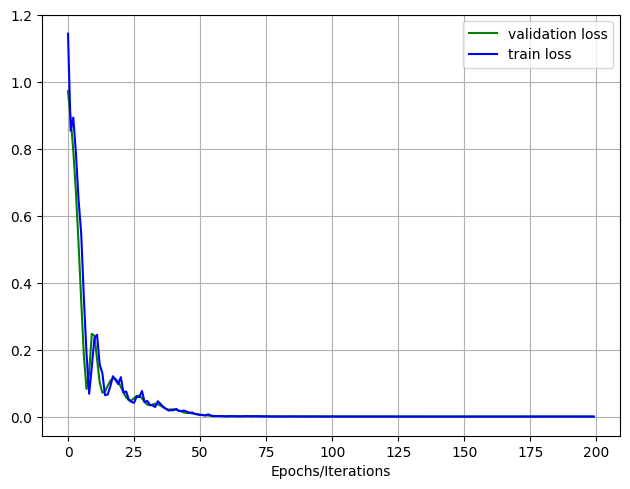

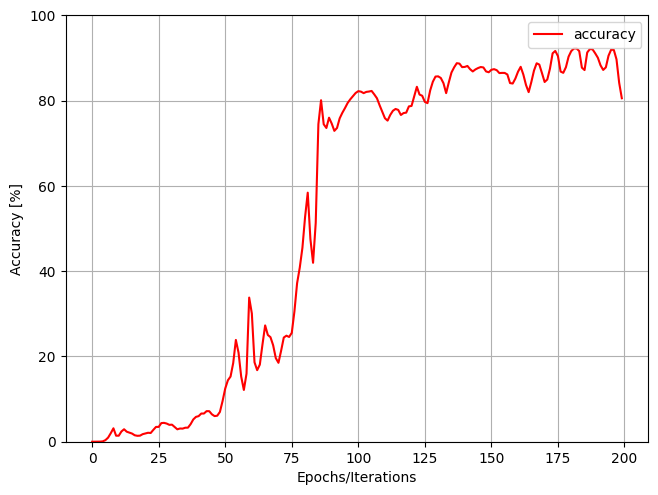

In [439]:
epochs = 200
tl = []
vl = []
a = []
for t in tqdm(range(epochs)):
    # print(f"Epoch {t+1}\n-------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(train_dataloader, model, loss_fn)
    tl.append(train_loss)
    vl.append(test_loss)
    a.append(accuracy)
print("Done!")
plt.plot(vl, 'g', label='validation loss')
plt.plot(tl, 'b', label='train loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xlabel("Epochs/Iterations")

plt.show()

plt.plot(a, 'r', label='accuracy')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xlabel("Epochs/Iterations")
plt.ylabel("Accuracy [%]")
plt.ylim([0,100])
plt.show()

In [440]:
nodes_config = nodes_update
prob = 'incomplete'
val_lr = f'{lr}_lr'

n_epochs = f'{epochs}_epochs'
schema = '->'.join(map(str, [4] + nodes_config + [1]))
samples = f'{len(poly_data[0])}_samples'

model_name = '_'.join([n_epochs, samples, val_lr, schema, prob])

torch.save(model.state_dict(), os.path.join(path_to_models, model_name))

In [441]:
a = torch.tensor([0.5, 0.8, 0.3, 1])

In [442]:
y = gc.compute_integral(a)

In [443]:
y_pred = model(torch.atleast_2d(a))
y_pred

tensor([[0.8667]], grad_fn=<AddmmBackward0>)

In [444]:
a

tensor([0.5000, 0.8000, 0.3000, 1.0000])

Loading previously saved model

In [463]:
a = gc.compute_integral([0.8, 0.2, 0.1, 1])
b = model(torch.atleast_2d(torch.tensor([0.8, 0.2, 0.1, 1])))
outs = [a,
      b.item(),
      ((a - b)/a).item()]

outs = list(map(lambda x: f'{x:.3f}', outs))
outs[-1] = f'{float(outs[-1]):.3%}'
outs
print(*outs, '\n')

0.467 0.460 1.400% 

